In [1]:
import sys
import os
os.environ['CLMM_MODELING_BACKEND'] = 'ccl' # here you may choose ccl or nc (NumCosmo)
sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMM/examples/support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
from astropy.table import Table

clmm.__version__
import clmm.polaraveraging as pa
import clmm.galaxycluster as gc
import clmm.modeling as modeling
from clmm import Cosmology 
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis')
import statistics as stat
import resampling
import mock_data as mock
from scipy.optimize import curve_fit
import iminuit
from iminuit import Minuit

In [2]:
pwd

'/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/examples'

### Testing Modeling

In [3]:
mock_cosmo = Cosmology(H0=70.0, Omega_dm0=0.27-0.045, Omega_b0=0.045, Omega_k0=0.0)

In [4]:
cluster_z = 0.4
cluster_m = 10**15
c = 4
shapenoise = 0.05
shapenoise_scaled = shapenoise*(1 + cluster_z)

In [5]:
data = mock.generate_galaxy_catalog(cluster_m, 
                                    cluster_z, 
                                    c, 
                                    mock_cosmo, 
                                    200,
                                    'chang13', 
                                    zsrc_min = cluster_z + 0.1
                                    ,shapenoise = shapenoise
                                    ,ngals=100000)

"""Create GalaxyCluster object"""

cl = clmm.GalaxyCluster('cluster', 0, 0, cluster_z, data)

In [6]:
cl.galcat['chi1'] = 2*cl.galcat['e1']/(1 + cl.galcat['e1']**2 + cl.galcat['e2']**2)
cl.galcat['chi2'] = 2*cl.galcat['e2']/(1 + cl.galcat['e1']**2 + cl.galcat['e2']**2)
cl.compute_tangential_and_cross_components(geometry="flat", shape_component1 = 'chi1', shape_component2 = 'chi2', tan_component = 'chit', cross_component = 'chix',  is_deltasigma = False, cosmo = mock_cosmo)
cl.compute_tangential_and_cross_components(geometry="flat", shape_component1 = 'e1', shape_component2 = 'e2', tan_component = 'et', cross_component = 'ex',  is_deltasigma = False, cosmo = mock_cosmo)
bin_edges = pa.make_bins( 1, 2,15, method='evenlog10width')
profile_et = cl.make_binned_profile("radians", "Mpc", bins=bin_edges,cosmo=mock_cosmo,tan_component_in='et', cross_component_in='ex',
                       tan_component_out='gt', cross_component_out='gx', include_empty_bins= True,gal_ids_in_bins=True)
profile_chi = cl.make_binned_profile("radians", "Mpc", bins=bin_edges,cosmo=mock_cosmo,tan_component_in='chit', cross_component_in='chix',
                       tan_component_out='gt_chi', cross_component_out='gx_chi', include_empty_bins= True,gal_ids_in_bins=True)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


In [7]:
R = 2*(1 - np.mean(cl.galcat['chi1']**2 + cl.galcat['chi2']**2)/2)

In [8]:
R

1.978235321370442

In [9]:
cl

GalaxyCluster cluster: (ra=0.0, dec=0.0) at z=0.4
> 100000 source galaxies
> With columns: ra dec e1 e2 z ztrue id chi1 chi2 theta chit chix et ex

In [10]:
moo = clmm.Modeling(massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')

moo.set_cosmo(mock_cosmo)

moo.set_mass(cluster_m) 

moo.set_concentration(c)

In [11]:
def predict_reduced_tangential_shear(r, logm):

    m = 10.**logm 
    
    moo.set_mass(m) 
    
    moo.set_concentration(c)
    
    deltasigma = []
    
    for i, R in enumerate(r):
        
        galist = profile_et['gal_id'][i]
        
        mask = (cl.galcat['id'] == galist)
        
        z = cl.galcat['z'][galist]

        surface_density = np.mean(moo.eval_reduced_shear(R, cluster_z, z))
    
        deltasigma.append(surface_density)
        
    return deltasigma

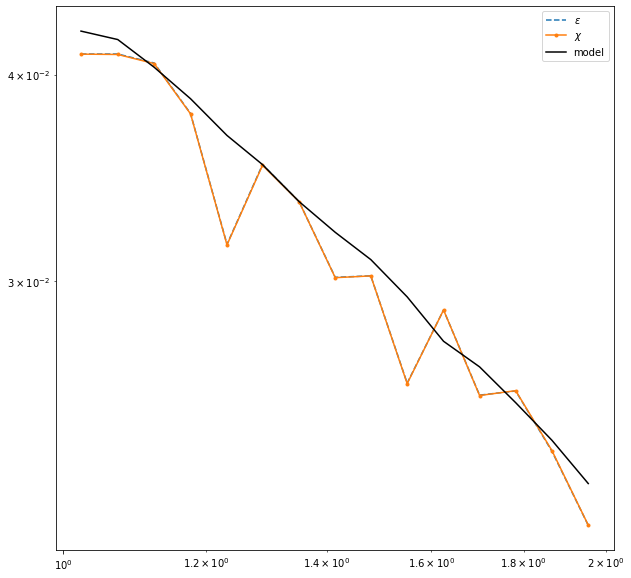

In [12]:
plt.figure(figsize=(10,10))
plt.loglog(profile_et['radius'], profile_et['gt'], '--', label = r'$\epsilon$')
plt.loglog(profile_chi['radius'], profile_chi['gt_chi']/R, '.-', label = r'$\chi$')
plt.plot(profile_et['radius'], predict_reduced_tangential_shear(profile_et['radius'], np.log10(cluster_m)), 'k', label = 'model')
plt.legend()

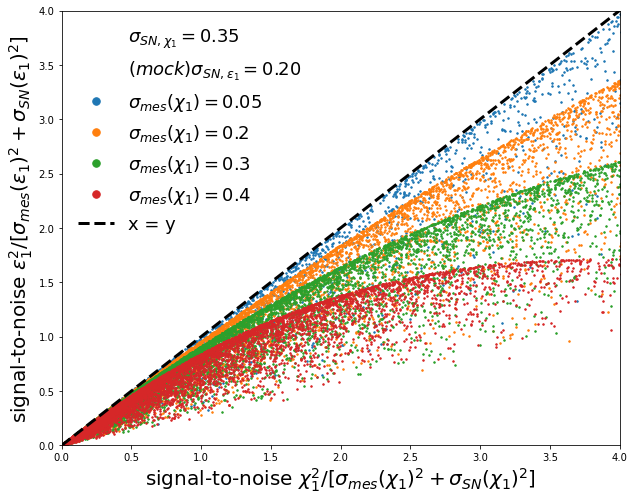

In [67]:
plt.figure(figsize=(10,8))


data = mock.generate_galaxy_catalog(cluster_m, 
                                    cluster_z, 
                                    c, 
                                    mock_cosmo, 
                                    200,
                                    'chang13', 
                                    zsrc_min = cluster_z + 0.1
                                    ,shapenoise = 0.2
                                    ,ngals=10000)


cl = clmm.GalaxyCluster('cluster', 0, 0, cluster_z, data)


cl.galcat['chi1'] = 2*cl.galcat['e1']/(1 + cl.galcat['e1']**2 + cl.galcat['e2']**2)
cl.galcat['chi2'] = 2*cl.galcat['e2']/(1 + cl.galcat['e1']**2 + cl.galcat['e2']**2)
sigma_SN_chi = np.std(cl.galcat['chi1'])
sigma_SN_epsi = np.std(cl.galcat['e1'])
cl.galcat['chi'] = np.sqrt(cl.galcat['chi1']**2 + cl.galcat['chi2']**2)
cl.galcat['epsi'] = np.sqrt(cl.galcat['e1']**2 + cl.galcat['e2']**2)
plt.plot([], [], 'w-', label = r'$\sigma_{SN,\chi_1} = $' + f'{sigma_SN_chi:.2f}')
plt.plot([], [], 'w-', label = r'$(mock) \sigma_{SN,\epsilon_1} = $' + f'{sigma_SN_epsi:.2f}')


marker = ['o','p','s','^']
for i, err_measure_chi in enumerate([0.05, 0.2, 0.3, 0.4]):
    
    cl.galcat['rms_chi1_shape'] = abs((err_measure_chi) + 0.0*np.random.randn(len(cl.galcat['chi1'])))
    cl.galcat['rms_chi2_shape'] = abs((err_measure_chi) + 0.0*np.random.randn(len(cl.galcat['chi1'])))
    cl.galcat['rms_chi_shape'] = np.sqrt(cl.galcat['rms_chi1_shape']**2 + cl.galcat['rms_chi2_shape']**2)
    cl.galcat['rms_chi_tot'] = np.sqrt(cl.galcat['rms_chi_shape']**2)# + np.std(cl.galcat['chi'])**2)
    cl.galcat['rms_epsi_shape'] = ((1./(1. + (1. - cl.galcat['chi']**2)**0.5)) * (1. + cl.galcat['chi']**2./(1. + ( 1. - cl.galcat['chi']**2)**0.5 * (1 - cl.galcat['chi']**2))))*cl.galcat['rms_chi_shape']
    cl.galcat['rms_epsi_tot'] = np.sqrt(cl.galcat['rms_epsi_shape']**2)# + np.std(cl.galcat['epsi'])**2)
    sn_epsi = abs(np.sqrt(2)*cl.galcat['e1']/cl.galcat['rms_epsi_tot'])
    sn_chi = abs(np.sqrt(2)*cl.galcat['chi1']/cl.galcat['rms_chi_tot'])
    plt.plot(sn_chi**2,sn_epsi**2, '.', markersize =3, label = r'$\sigma_{mes}(\chi_1) = $' + f'{err_measure_chi}')

plt.plot(np.linspace(0,100,100),np.linspace(0,100,100),'--k', linewidth=3, label='x = y')
plt.legend(fontsize = 18,markerscale=5., frameon=False)

plt.xlim(0,4)
plt.ylim(0,4)

plt.ylabel(r'signal-to-noise $\epsilon_1^2/[\sigma_{mes}(\epsilon_1)^2 + \sigma_{SN}(\epsilon_1)^2]$', fontsize = 20)
plt.xlabel(r'signal-to-noise $\chi_1^2/[\sigma_{mes}(\chi_1)^2 + \sigma_{SN}(\chi_1)^2]$', fontsize = 20)
plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/sn_chi.png', dpi = 300)